In [2]:
import jax.numpy as jnp
import numpy as np
import jax
from flax import nnx
import optax
from flax.training import train_state
import scipy
from scipy.spatial.distance import cdist
from scipy.integrate import RK45
import matplotlib.pyplot as plt

seed = 42
np.random.seed(42)


generate dataset:

$\frac{ds(x)}{dx} = g(s(x), u(x), x), x \in [0,1]$, $s(0) = 0$


goal: predict $s(x)$ over whole domain $[0,1]$ for any $u(x)$ 

this is basically learning the integration operator $u(x) \rightarrow s(x) = \int_0^x u(\tau)d\tau$

In [3]:
# kernel for gaussian random field function
def rbf_kernel(X, Y, length_scale = 1.0, variance = 1.0):
    dists = cdist(X, Y, metric = 'sqeuclidean')
    return variance * np.exp(-0.5 * dists/ length_scale ** 2)

# sample from gaussian random field, how you generate random initial conditions
# n_points = smoothness on domain [0,1], length_scale controls smoothness
def sample_grf(n_points = 100, n_dims = 1, length_scale = 1.0, variance = 1.0, n_samples = 5, random_state = seed):
    rng = np.random.default_rng(random_state)
    if n_dims == 1:
        X = np.linspace(0, 1, n_points)[:, None]
    else:
        X = rng.uniform(0, 1, size = (n_points, n_dims))

    K = rbf_kernel(X,X, length_scale = length_scale, variance = variance)
    samples = rng.multivariate_normal(mean = np.zeros(n_points), cov = K, size = n_samples)
    return X, samples

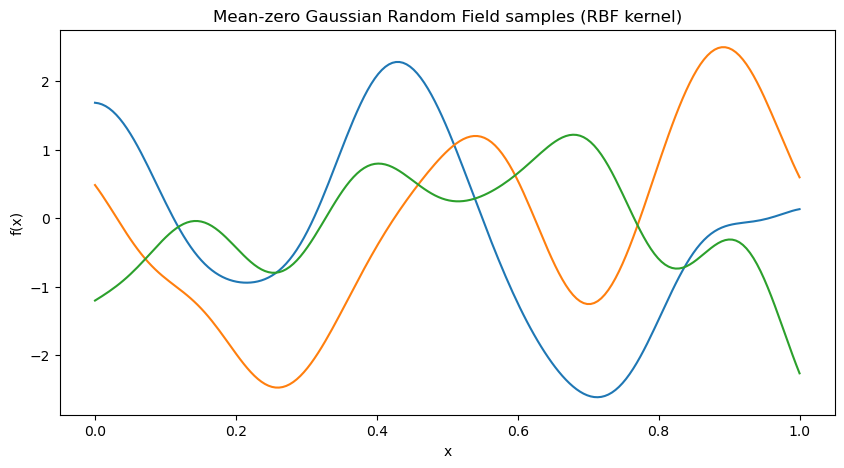

In [4]:
x, samples = sample_grf(n_points = 200, n_dims = 1, length_scale= 0.1, variance = 2.0, n_samples = 3, random_state = seed)
plt.figure(figsize=(10, 5))
for s in samples:
    plt.plot(x, s)
plt.title("Mean-zero Gaussian Random Field samples (RBF kernel)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

could also potentially get ICs sampling from space of Chebyshev 1st kind polynomials

In [5]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

u = samples[0]
x = x.reshape(-1)

u_interp = interp1d(x,u, kind="cubic", fill_value = "extrapolate")

def rhs(x,F):
    return u_interp(x) # dF/dx = u(x)

sol = solve_ivp(rhs, [0, 1], [0], method = "RK45", t_eval = x)

In [6]:
F_rk45 = sol.y[0]

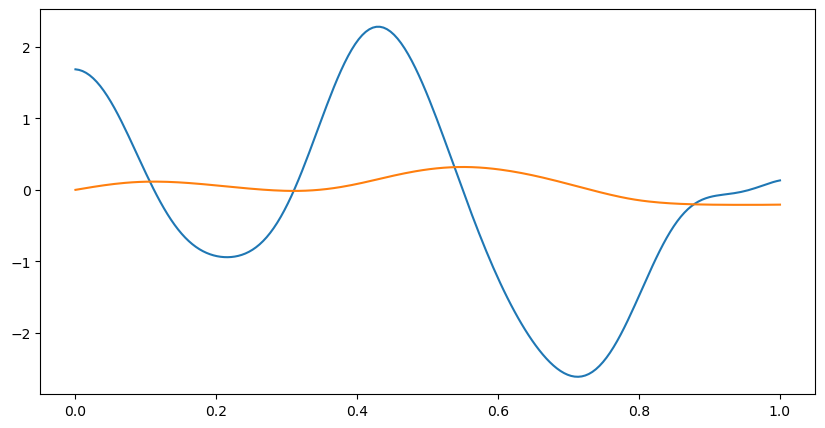

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(x, u)
plt.plot(x, F_rk45)